## Motivation


The primary cause of poor performance of students during the learning process is confusion. To make online education more effective, it is important to detect confusion in real-time. While Massive Open Online Courses (MOOCs) cater to a large number of students simultaneously, they have certain drawbacks in comparison to traditional in-class education. Currently, attempts are being made to enhance communication between instructors and students through interactive tools. Pervious work [2] has shown the effectivness of applying bidirectional LSTM on this dataset. I expermint with variations of LSTM as reported in [3] to improve on the current state of the art. 



## Dataset Information 

The dataset consists of EEG signal data collected from 10 college students while they watched MOOC video clips. The EEG signal can help detecting students mental states by acquiring signals from the brain.These 10 students were assigned to watch 20 videos, 10 of which were pre-labeled as “easy” and 10 as “difficult”. First, several online education videos were selected that were assumed not to be confusing for the students. Each video was about 2 minutes long. For “difficult” videos, the two-minute clip was taken abruptly from the middle of a topic to make the videos more confusing. The dataset was prepared by randomly selecting 5 videos from each category for each student. The dataset has a total of 12811 samples. On an average there are 120 samples for each data points. There are 100 datapoints, 10 coming from each student. 


| Feature | Description | Sampling Rate | Statistic |             
| :- | :- | :- | :- |
|Attention|Proprietary measure of mental focus|1 Hz|Mean|      
|Meditation|Proprietary measure of calmness|1 Hz|Mean|              
|Raw|Raw EEG signal|512 Hz|Mean|              
|Delta|1–3 Hz of power spectrum|8 Hz|Mean|
|Theta|4–7 Hz of power spectrum|8 Hz|Mean|
|Alpha1|Lower 8–11 Hz of power spectrum|8 Hz|Mean
|Alpha2|Higher 8–11 Hz of power spectrum|8 Hz|Mean|
|Beta1|Lower 12–29 Hz of power spectrum|8 Hz|Mean|
|Beta2|Higher 12–29 Hz of power spectrum|8 Hz|Mean|
|Gamma1|Lower 30–100 Hz of power spectrum|8 Hz|Mean|
|Gamma2|Higher 30–100 Hz of power spectrum|8 Hz|Mean|

There are two label columns — user-defined label (self-labeled by the students based on their experience) and predefined label (where they are expected to be confused).

 
## Project Overview 

The project deals with using the bidirectional LSTM networks with attention to correctly identify confusion among students.

## References
1. Wang, H., Li, Y., Hu, X., Yang, Y., Meng, Z., & Chang, K. M. (2013, June). Using EEG to Improve Massive Open Online Courses Feedback Interaction. In AIED Workshops.

2. Ni, Z., Yuksel, A. C., Ni, X., Mandel, M. I., & Xie, L. (2017). Confused or not Confused?: Disentangling Brain Activity from EEG Data Using Bidirectional LSTM Recurrent Neural Networks. ACM-BCB ... ... : the ... ACM Conference on Bioinformatics, Computational Biology and Biomedicine. ACM Conference on Bioinformatics, Computational Biology and Biomedicine, 2017, 241–246. https://doi.org/10.1145/3107411.3107513

3. Walther, D., Viehweg, J., Haueisen, J., & Mäder, P. (2023). A systematic comparison of deep learning methods for EEG time series analysis. Frontiers in Neuroinformatics, 17, 6.



# **1. Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization,LSTM,Bidirectional,MaxPooling2D,GlobalMaxPooling2D,TimeDistributed, Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix


# **2. Loading and Preprocessing the data**

In [3]:
data = pd.read_csv('EEG_data.csv')
data.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [4]:
demographic_data = pd.read_csv('demographic_info.csv')
demographic_data = demographic_data.rename(columns = {'subject ID':'SubjectID'})
demographic_data
#data = data.merge(demographic_data,how = 'inner',on = 'SubjectID')
#data.head()

,SubjectID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M
5,5,24,Han Chinese,M
6,6,24,Han Chinese,M
7,7,25,Han Chinese,M
8,8,25,Han Chinese,M
9,9,24,Han Chinese,F


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


In [6]:
data.nunique()

SubjectID                10
VideoID                  10
Attention                61
Mediation                61
Raw                    1104
Delta                 12280
Theta                 12070
Alpha1                11140
Alpha2                10910
Beta1                 10583
Beta2                 10936
Gamma1                10197
Gamma2                 8901
predefinedlabel           2
user-definedlabeln        2
dtype: int64

**Comments**:<br>
There are no missing values in the dataset.

In [7]:
data.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


**Comments**:<br> 
"Meditation and attention have some values as zero which doesn't make sense at all. As specified by the author of the dataset, these values may be due to problems during data collection .i.e. incorrect position of the device on the head by the student."



Features like SubjectID and VideoID do not provide any useful info to the analysis of EGG brainwaves, thus they're dropped. 

The target is the 'user-definedlabel' since it is the label that indicates if a signal is correlated to a confusion state.

### Cleaning the data

In [8]:
dataset = data.copy()
dataset = dataset[dataset['Attention'] > 0.0]
dataset = dataset[dataset['Mediation'] > 0.0]
dataset_all = dataset.copy()
dataset.drop(columns = ['SubjectID','VideoID','predefinedlabel'],inplace=True)


In [9]:
print("After cleaning, the data has {} rows and {} columns.".format(dataset.shape[0],dataset.shape[1]))

After cleaning, the data has 11388 rows and 12 columns.


### Normalization and standarization

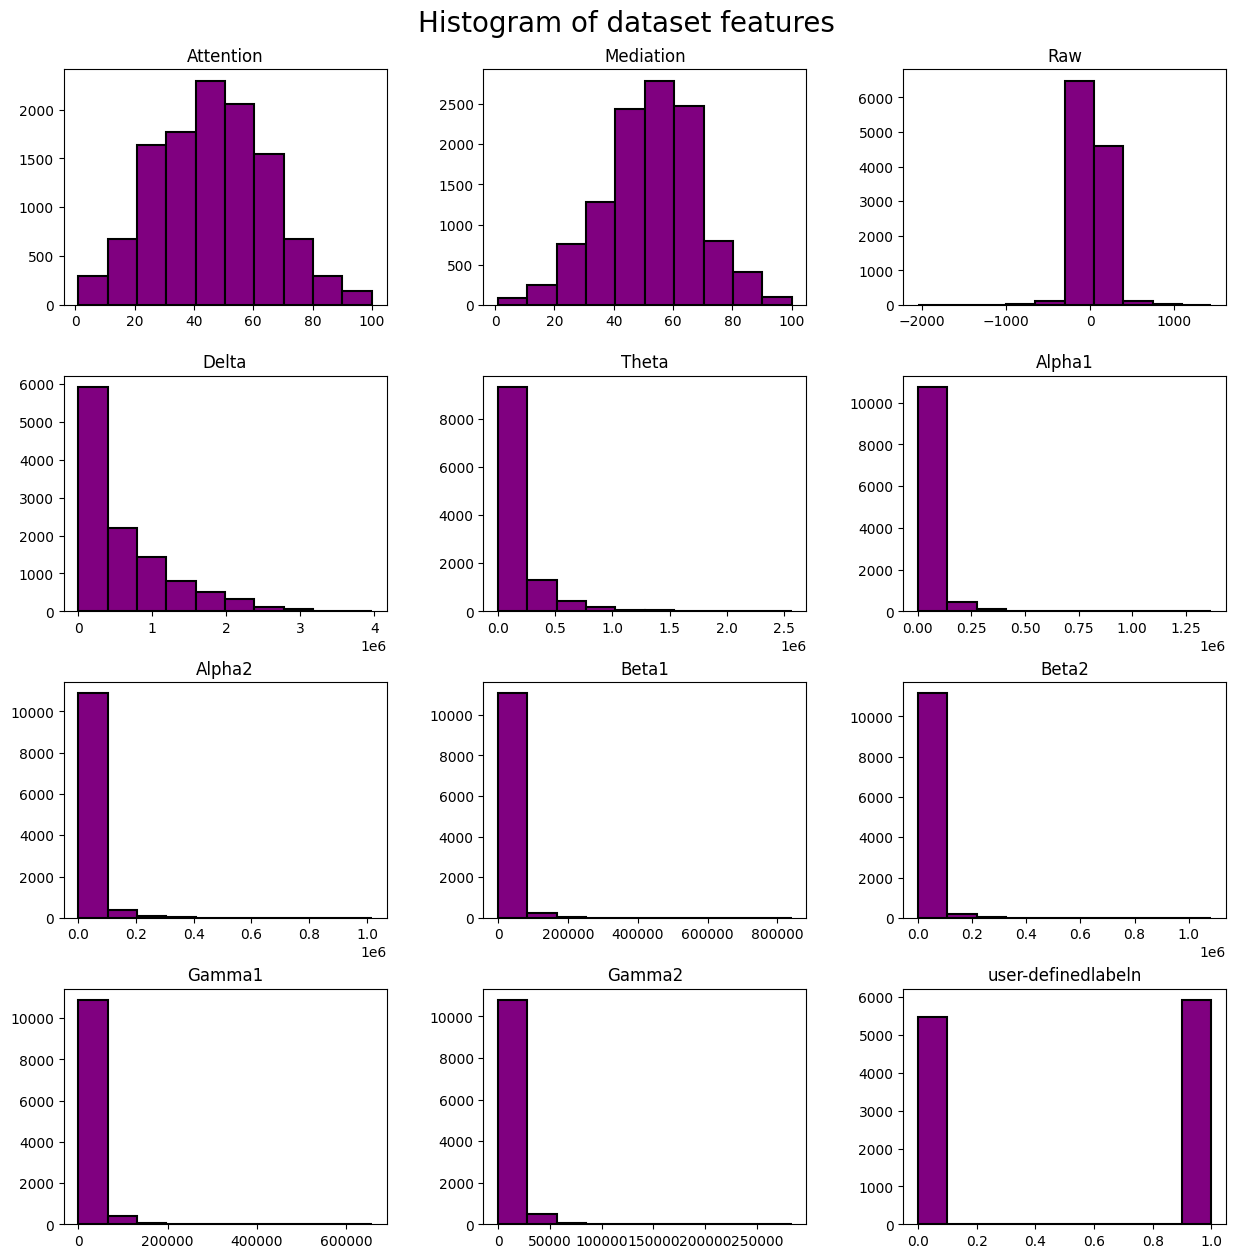

In [10]:
dataset.hist(figsize = (15,15), grid = False, color = "purple", edgecolor = 'black',linewidth = 1.5 )
plt.suptitle('Histogram of dataset features',fontsize = 20,y= 0.92)
plt.show()

**Comments**:<br> **
The above histograms shows that most of the features have their distributions skewed. The histogram of target user-definedlabeln shows that the dataset is fairly balanced. The skewness in the distribution has to be be removed.Some of the features are not spread across the entire range. Also, feature scales are very different. So appropriate normalization needs to be applied to spread the data over the normalized range and yield maximum information from the given data.

array([[<Axes: title={'center': 'Delta'}>,
        <Axes: title={'center': 'Theta'}>,
        <Axes: title={'center': 'Alpha1'}>],
       [<Axes: title={'center': 'Alpha2'}>,
        <Axes: title={'center': 'Beta1'}>,
        <Axes: title={'center': 'Beta2'}>],
       [<Axes: title={'center': 'Gamma1'}>,
        <Axes: title={'center': 'Gamma2'}>, <Axes: >]], dtype=object)

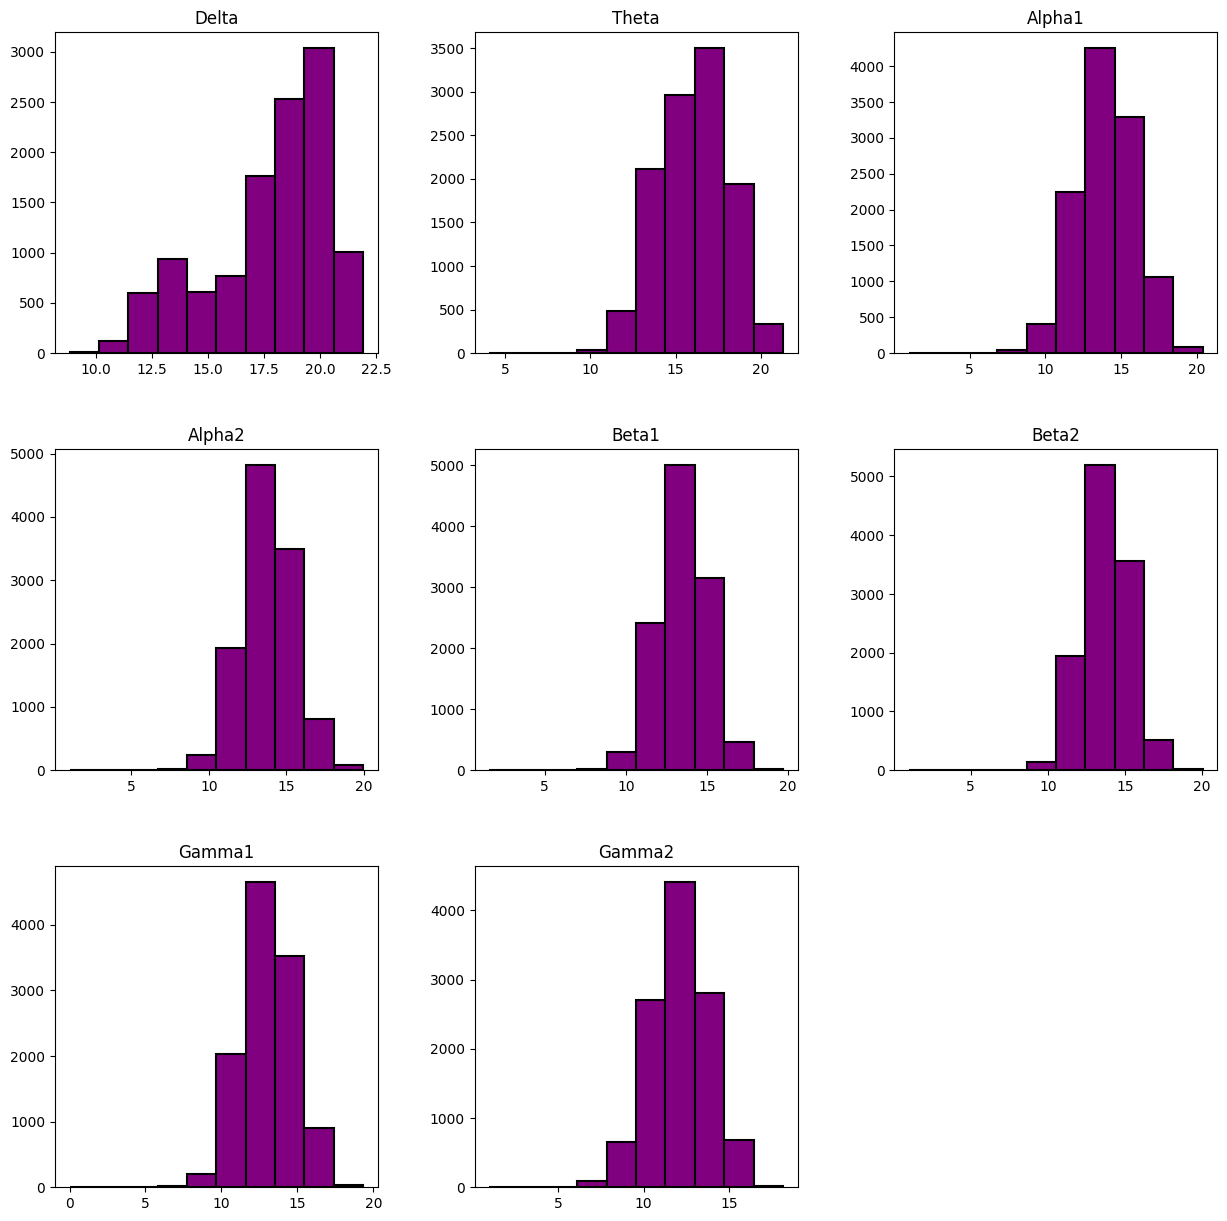

In [11]:
#Applying non-linear normalization for spreading the data
X_n = dataset.iloc[:,:-1].copy() #data that will be normalized
X_n.iloc[:,3:11] = np.log2(X_n.iloc[:,3:11] + 0.0001) #spreading the amount data using log normalization technique
X_n.iloc[:,3:11].hist(figsize = (15,15), grid = False, color = "purple", edgecolor = 'black',linewidth = 1.5 )

**Comments**:<br>
 now i use a combination of tanh normalization and robust scaleing for transforming the data i.e. spreading the data and scaling it in the range [-1,1]

In [12]:
m = np.mean(X_n, axis=0) # array([16.25, 26.25])
std = np.std(X_n, axis=0) # array([17.45530005, 22.18529919])
md = np.median(X_n,axis = 0)
p75 = np.percentile(X_n,75,axis = 0)
p25 = np.percentile(X_n,25,axis = 0)

In [13]:
X_n = np.tanh((X_n - md) / (p75 - p25)) #normalization and feature scaling for train set

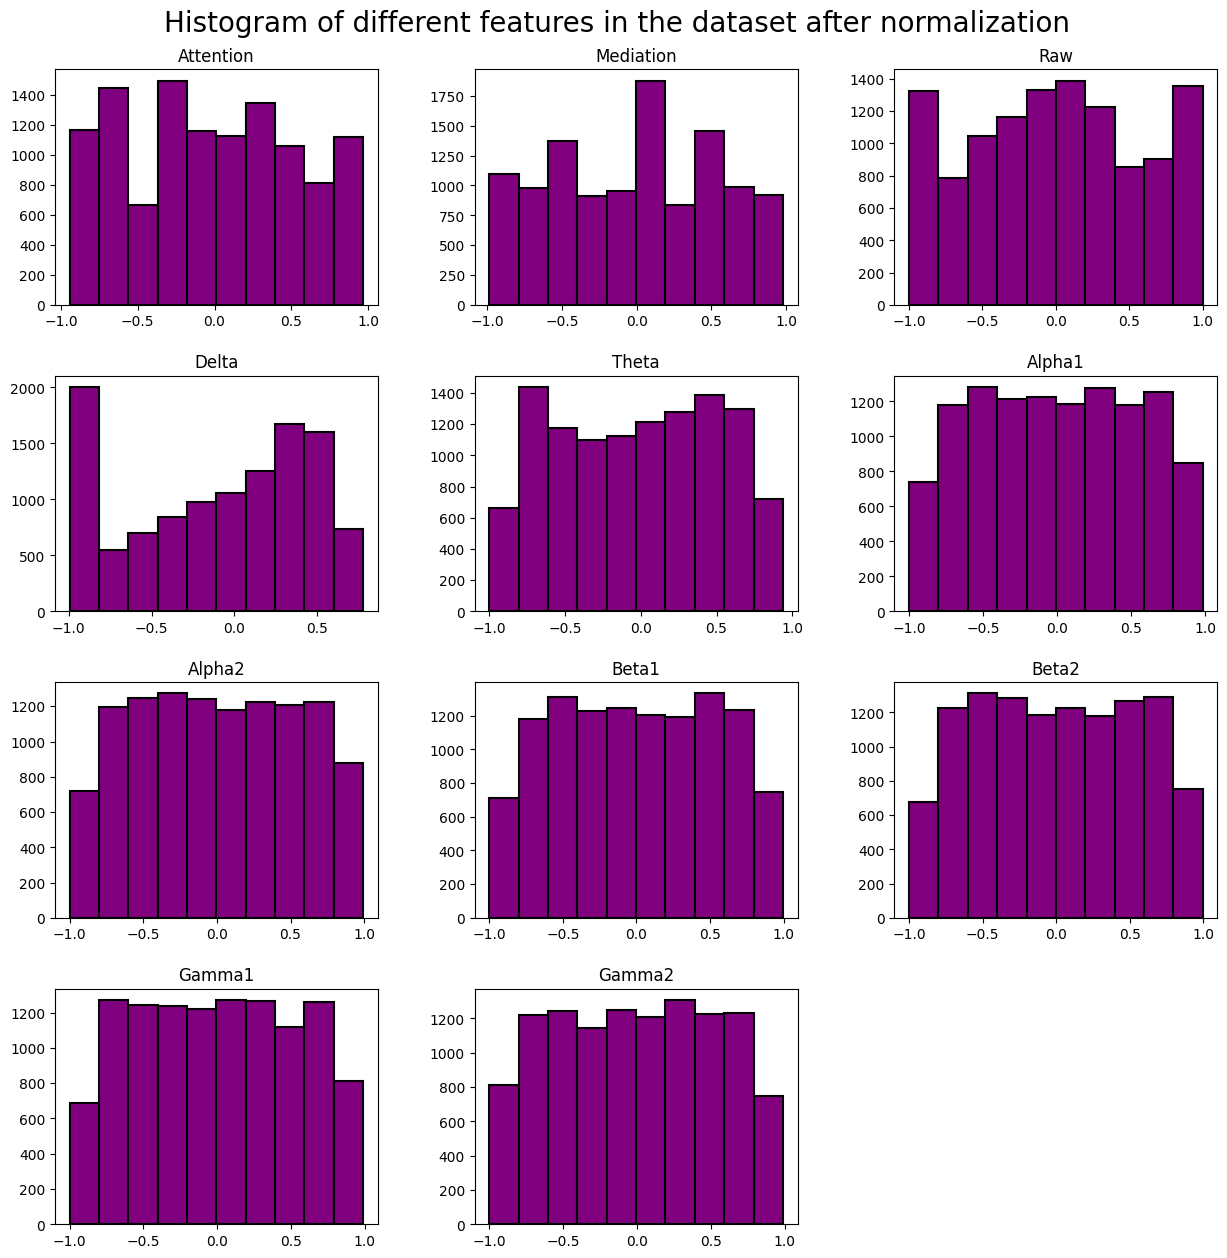

In [14]:
X_n.hist(figsize = (15,15), grid = False, color = "purple", edgecolor = 'black',linewidth = 1.5 )
plt.suptitle('Histogram of different features in the dataset after normalization',fontsize = 20,y= 0.92)
plt.show()

**Comment**: <br>
All the features have been spread and scaled in the range [-1,1].

<Axes: >

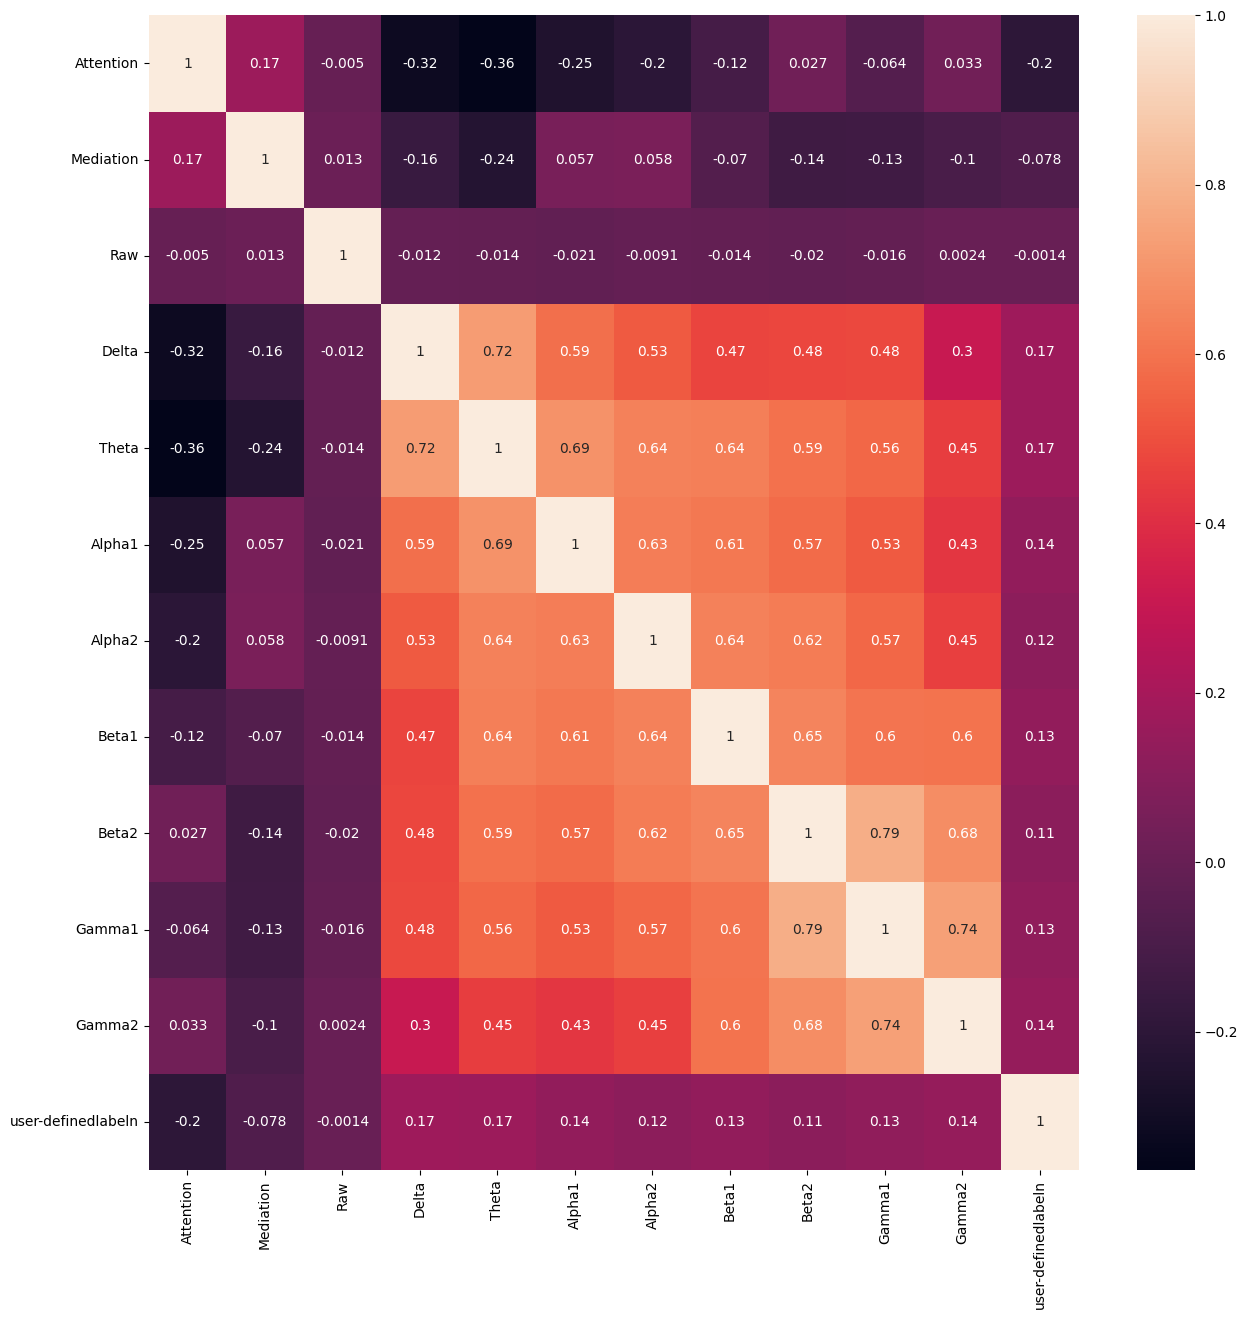

In [15]:
plt.figure(figsize = (15,15))
cor_matrix = pd.concat((X_n,dataset_all['user-definedlabeln']),axis = 1).corr()
sns.heatmap(cor_matrix,annot=True)

In [16]:
df = data.rename(columns={"user-definedlabeln": "userlabel"})


In [17]:
df_new = df.reset_index().drop(df.index)

for i in range(0,10):
  for j in range(0,10):
    query = "SubjectID == "+str(i)+" & VideoID == "+str(j)
    df_temp = df.query(query)
    df_temp = df_temp.reset_index(drop=True)
    df_temp = df_temp.reset_index()
    # print(df_temp)
    df_new = pd.concat([df_new, df_temp])

df_new = df_new.rename(columns={"index": "timepoint"})
df_new = df_new.reset_index(drop=True)
df_new.head()

,timepoint,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,userlabel
0,0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [18]:
def draw_multiple_figures(df_confused,df_understand):
  sns.set(rc={'figure.figsize':(30,8.27)})

  fig, axs = plt.subplots(5, 2)

  sns.lineplot(data=df_confused, x="timepoint", y="Attention",errorbar=None, ax=axs[0,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Attention",errorbar=None, ax=axs[0,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Mediation",errorbar=None, ax=axs[0,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Mediation",errorbar=None, ax=axs[0,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Alpha1",errorbar=None, ax=axs[1,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Alpha1",errorbar=None, ax=axs[1,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Alpha2",errorbar=None, ax=axs[1,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Alpha2",errorbar=None, ax=axs[1,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Beta1",errorbar=None, ax=axs[2,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Beta1",errorbar=None, ax=axs[2,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Beta2",errorbar=None, ax=axs[2,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Beta2",errorbar=None, ax=axs[2,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Gamma1",errorbar=None, ax=axs[3,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Gamma1",errorbar=None, ax=axs[3,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Gamma2",errorbar=None, ax=axs[3,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Gamma2",errorbar=None, ax=axs[3,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Delta",errorbar=None, ax=axs[4,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Delta",errorbar=None, ax=axs[4,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Theta",errorbar=None, ax=axs[4,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Theta",errorbar=None, ax=axs[4,1])

  fig.legend(labels=['confused','not confused'], loc="lower center", ncol=2)
  fig.suptitle("Confused vs Not Confused by Groups of Frequency")

  plt.show()

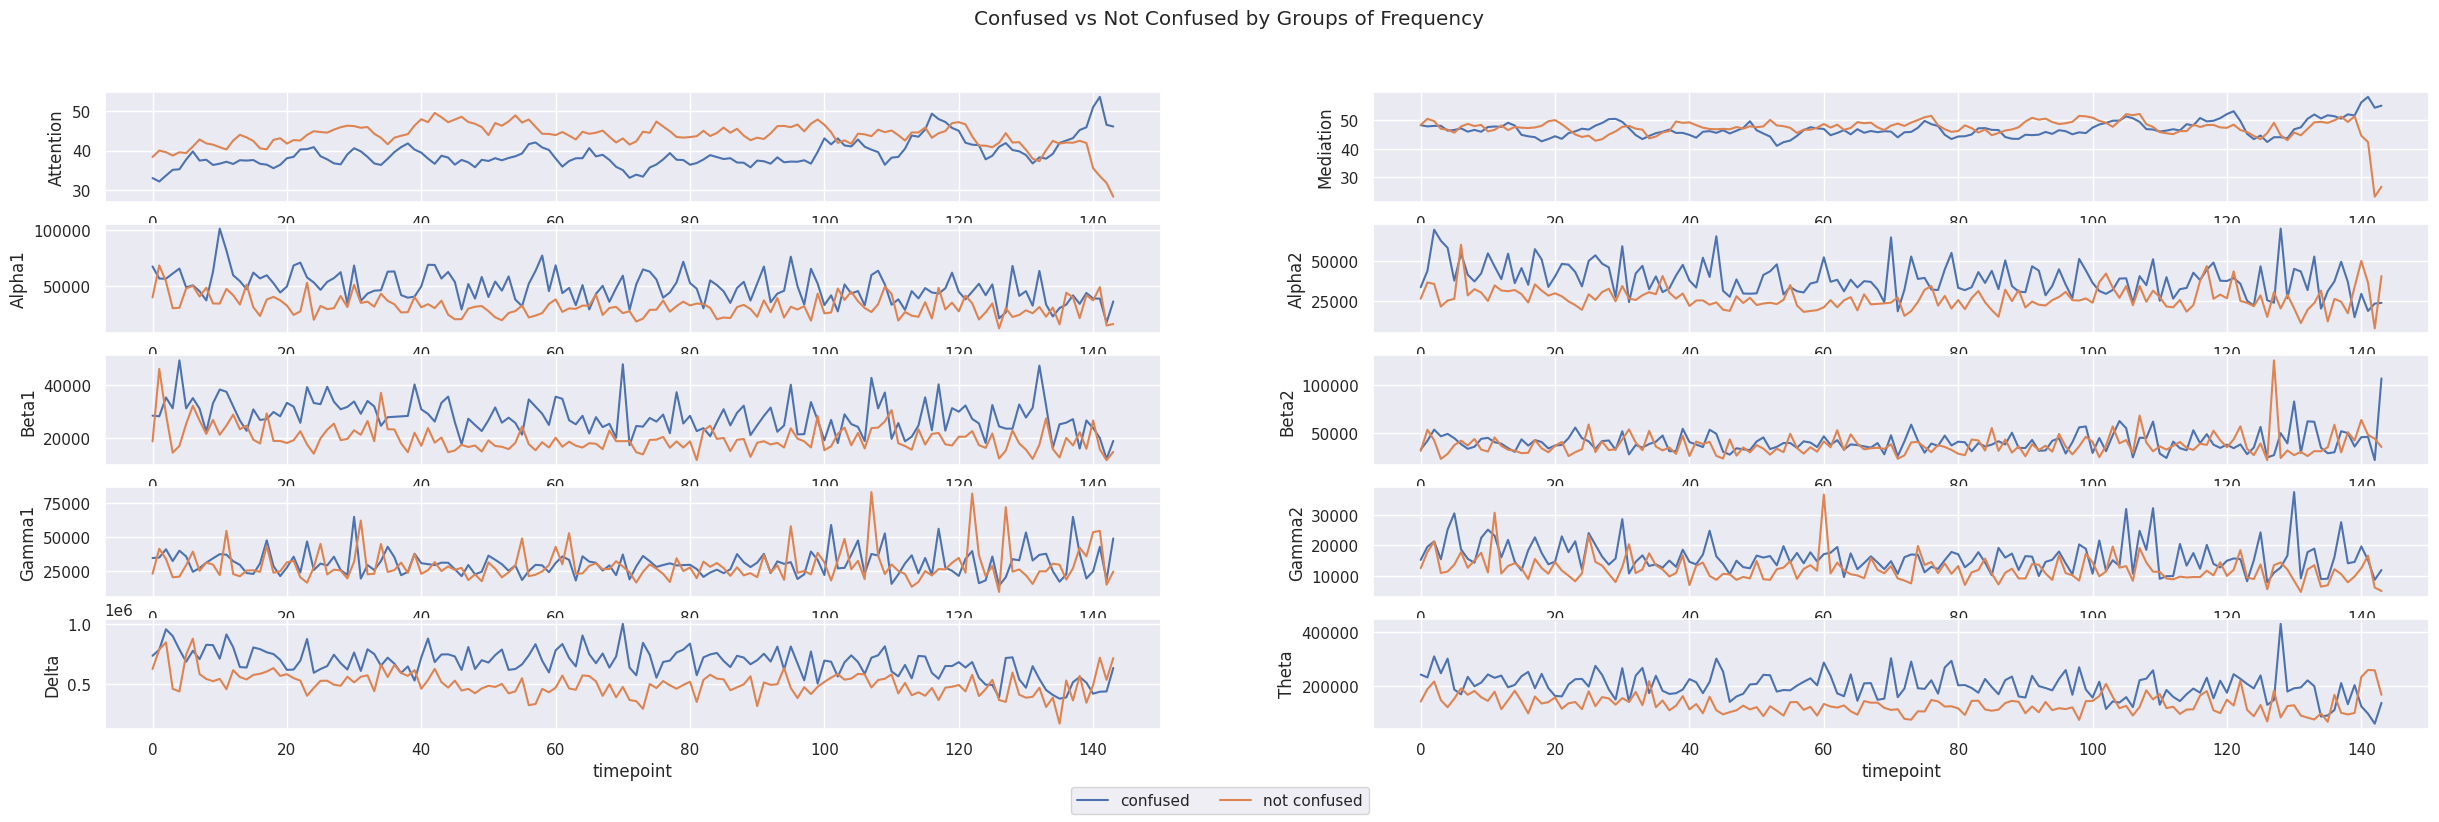

In [19]:
#Comparison between Confused vs Not Confused in dataset labeled by subjects.¶

query = "userlabel == 1"
df_confused = df_new.query(query)

query = "userlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

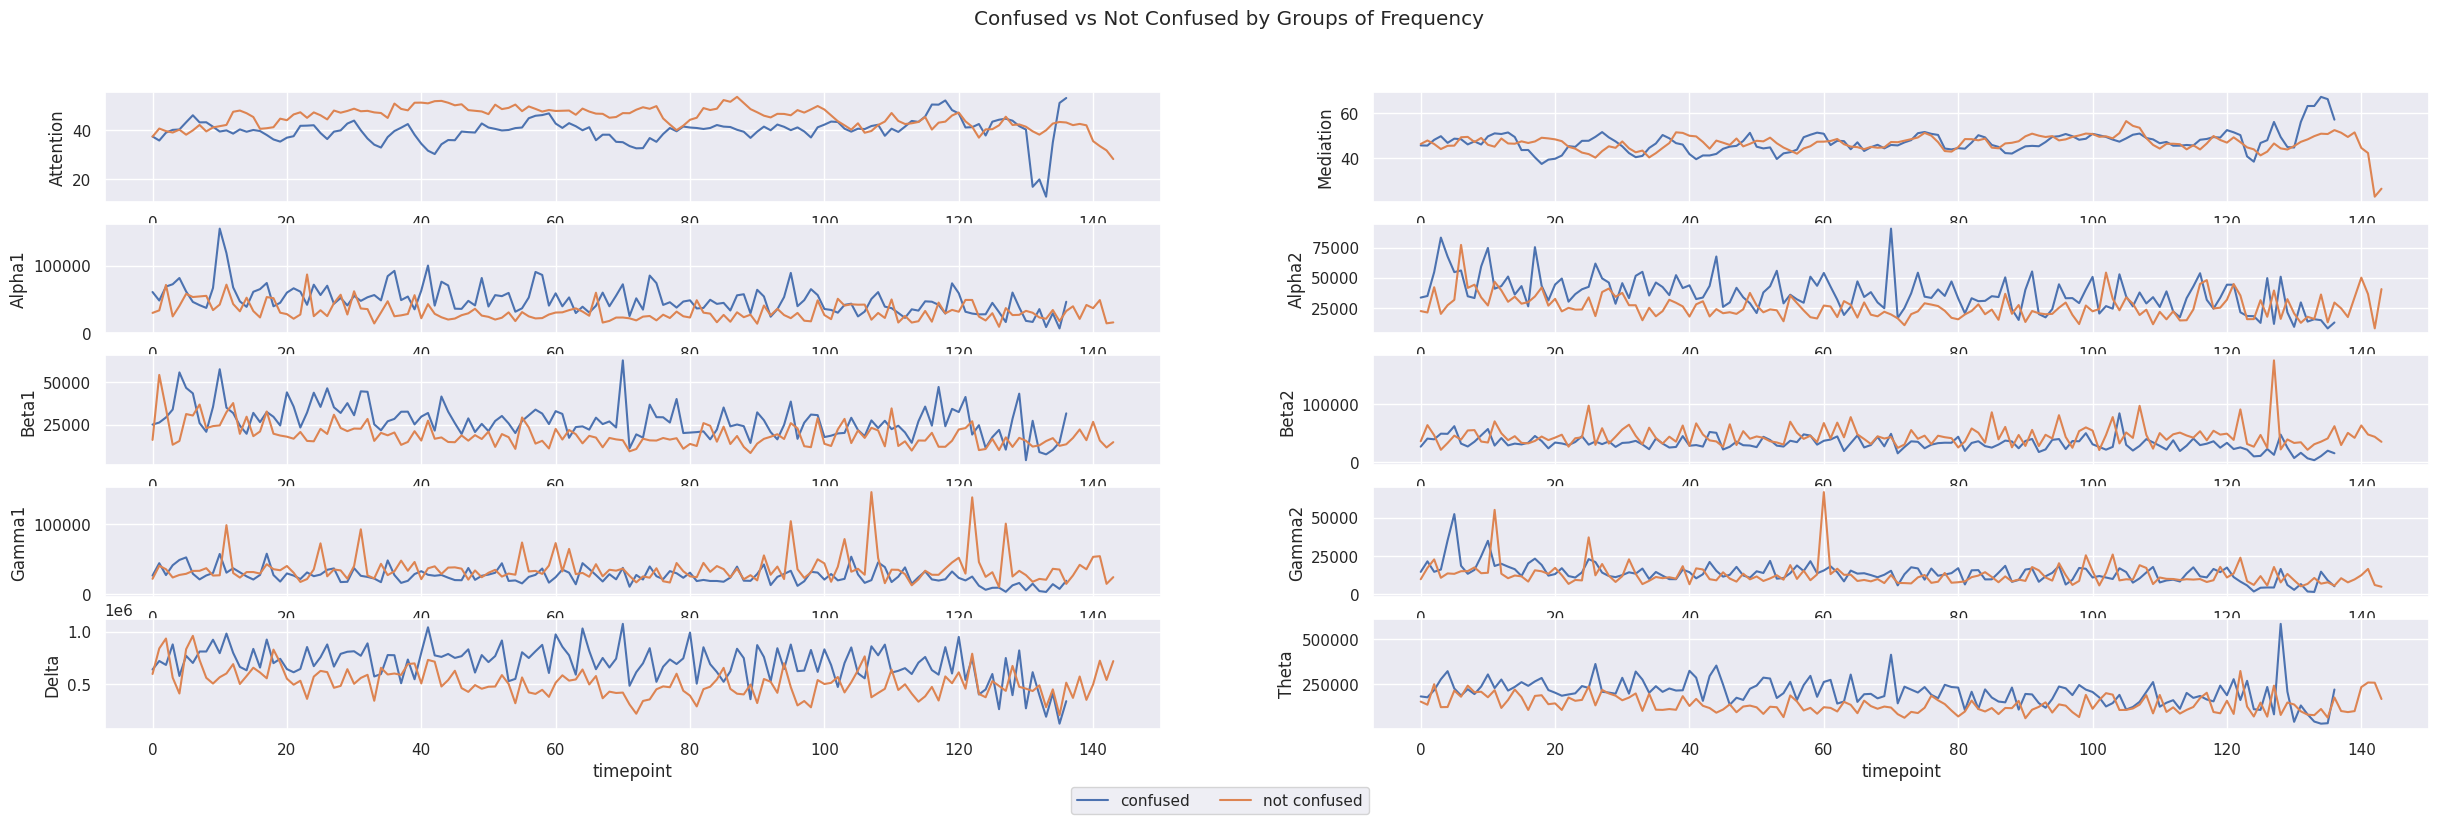

In [20]:
#Comparison between Confused vs Not Confused in dataset same-labeled by the author and subjects.¶
query = "predefinedlabel == 1 & userlabel == 1"
df_confused = df_new.query(query)

query = "predefinedlabel == 0 & userlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

# **3. Creating dataset**

In [21]:
X = X_n #features
Y = dataset.iloc[:,-1] #targets

In [22]:
dataset

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,user-definedlabeln
0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0
3,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0
4,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12806,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,0.0
12807,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,0.0
12808,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,0.0
12809,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,0.0


In [23]:
X

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
0,0.332960,-0.443188,0.991204,-0.086308,0.098969,0.373519,0.340371,0.543595,0.672092,0.680691,0.359422
1,-0.262909,-0.694783,-0.732144,-0.604119,-0.437196,-0.871669,-0.829138,-0.764677,-0.732003,-0.290644,-0.307803
2,0.000000,-0.233696,0.631823,0.304181,0.663606,0.879922,0.749678,0.659172,0.914821,0.822624,0.792037
3,0.000000,0.188206,-0.408103,0.628358,0.265388,0.616871,0.133217,-0.010175,0.778633,0.793642,0.850950
4,-0.114875,0.000000,-0.435502,0.410905,0.641404,0.417578,0.835171,0.737931,0.878135,0.767420,0.826535
...,...,...,...,...,...,...,...,...,...,...,...
12806,0.574253,-0.613357,-0.670203,-0.431220,-0.749522,-0.938906,0.282402,-0.645735,0.620662,-0.627266,-0.751185
12807,0.491823,-0.694783,-0.997918,-0.057077,0.819053,0.840670,0.909812,0.694258,0.988731,0.711098,0.457544
12808,0.462117,-0.815374,-0.999927,0.261115,0.342933,0.451825,0.586345,-0.042553,0.426726,0.486302,-0.468397
12809,0.462117,-0.815374,-0.864556,-0.002525,-0.447568,-0.198542,-0.214816,-0.848240,-0.767422,0.216914,-0.532922


In [24]:
X.shape

(11388, 11)

In [25]:
list(X)

['Attention',
 'Mediation',
 'Raw',
 'Delta',
 'Theta',
 'Alpha1',
 'Alpha2',
 'Beta1',
 'Beta2',
 'Gamma1',
 'Gamma2']

# Feature Importance

In [26]:
#A random forest classifier will be fitted to compute the feature importances.

from sklearn.ensemble import RandomForestClassifier

feature_names = list(X)
forest = RandomForestClassifier(random_state=0)
forest.fit(X, Y)


RandomForestClassifier(random_state=0)

In [27]:
import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.046 seconds


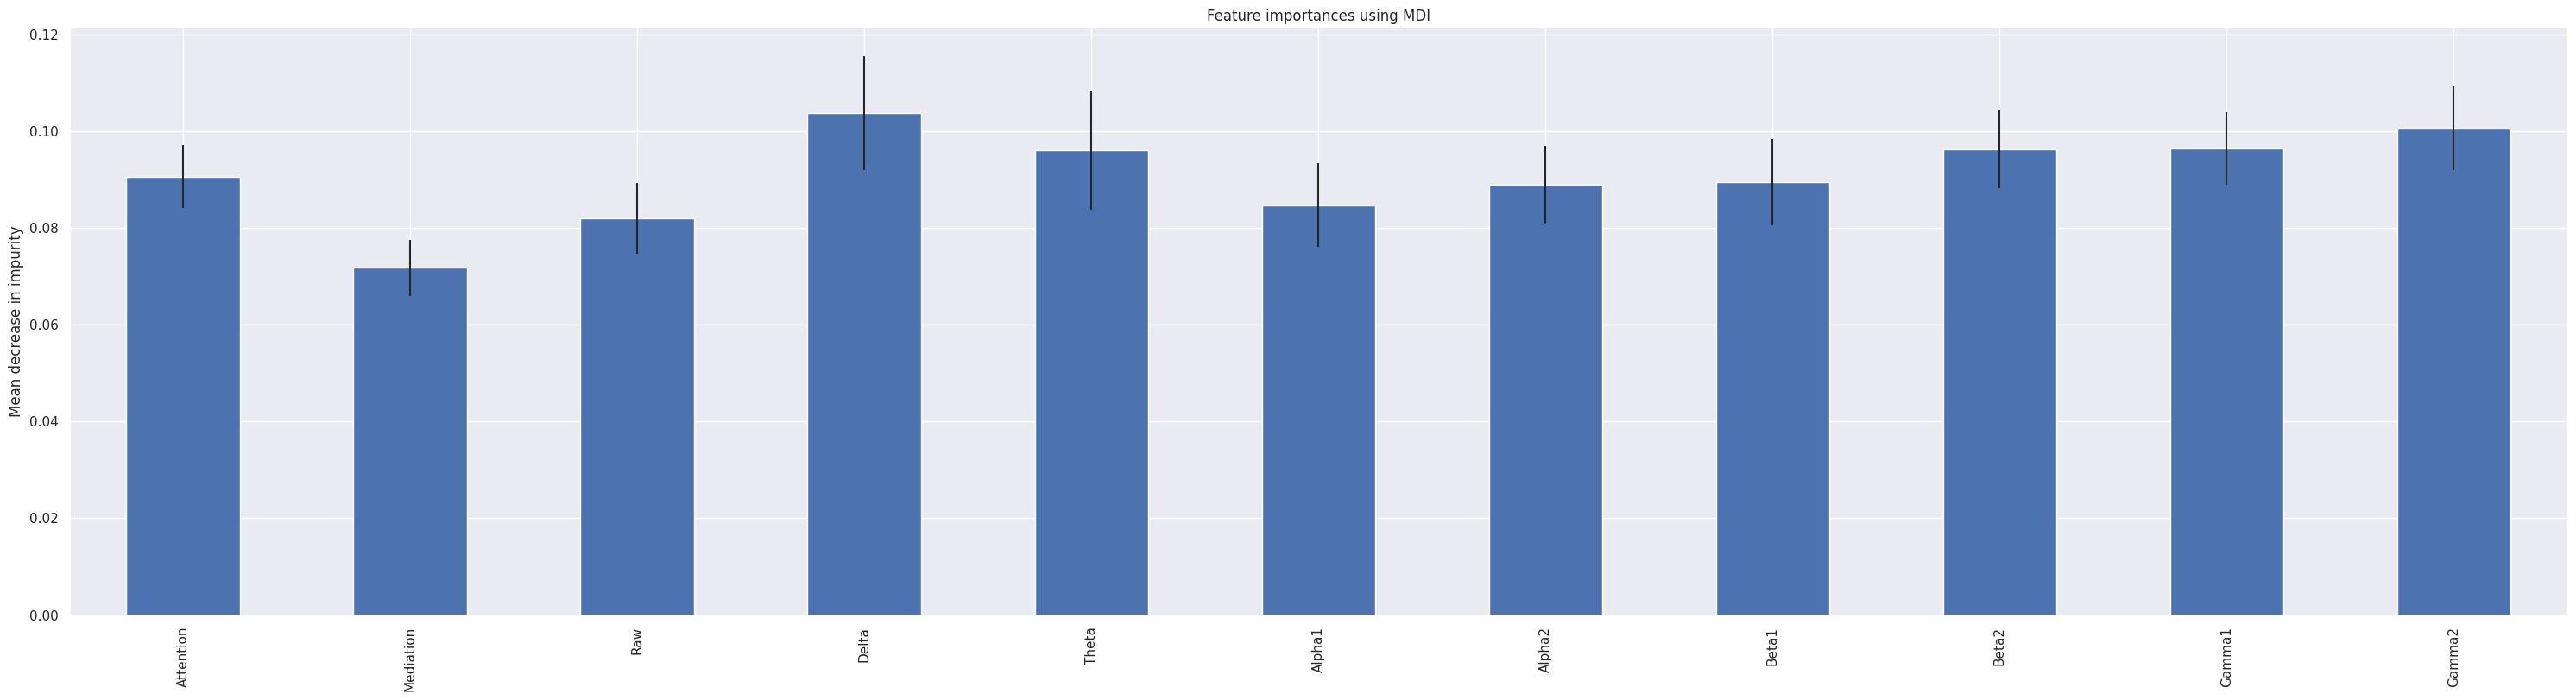

In [28]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

None of thiese feature seem to have drastically less importance compared to the rest

In [29]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
(selector.fit_transform(X)).shape

(11388, 11)

In [30]:
x_train,x_test,y_train,y_test = train_test_split(X, Y,test_size=0.2, random_state=42, stratify=Y)

In [31]:

n_features = X.shape[1]
x_train = np.array(x_train).reshape(-1,n_features,1)
x_test = np.array(x_test).reshape(-1,n_features,1)

x_train.shape, x_test.shape,y_train.shape,y_test.shape

((9110, 11, 1), (2278, 11, 1), (9110,), (2278,))


# **4.Predictive modelling using CNN + Bi-Directional LSTM**

Using CNN along with LSTM networks helps extracting useful signal features from the sequences.

In [32]:
def plotLearningCurve(history,epochs,text):
  epochRange = range(1,epochs+1)
  plt.figure(figsize = (5,5))
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy for ' + text)
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Accuracy', fontsize = 20)
  plt.legend(['Training set','Validation set'])
  plt.show()
  
  plt.figure(figsize = (5,5))
  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss for ' + text)
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Loss', fontsize = 20)
  plt.legend(['Training set','Validation set'])
  plt.show()

In [33]:
# Add attention layer to the deep learning network
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [37]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Attention


inputs = Input(shape=(n_features,1))

Dense1 = Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2())(inputs)

lstm_1=  Bidirectional(LSTM(128, return_sequences = True))(Dense1)
drop = Dropout(0.3)(lstm_1)
lstm_3=  Bidirectional(LSTM(64, return_sequences = True))(drop)
drop2 = Dropout(0.3)(lstm_3)
attention_1 = attention()(drop2)
#drop = Dropout(0.3)(attention_1)
flat = Flatten()(attention_1)

Dense_2 = Dense(64, activation = 'relu')(flat)
outputs = Dense(1, activation='sigmoid')(Dense_2)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 11, 1)]           0         
                                                                 
 dense_6 (Dense)             (None, 11, 64)            128       
                                                                 
 bidirectional_4 (Bidirectio  (None, 11, 256)          197632    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 11, 256)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 11, 128)          164352    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 11, 128)           0   

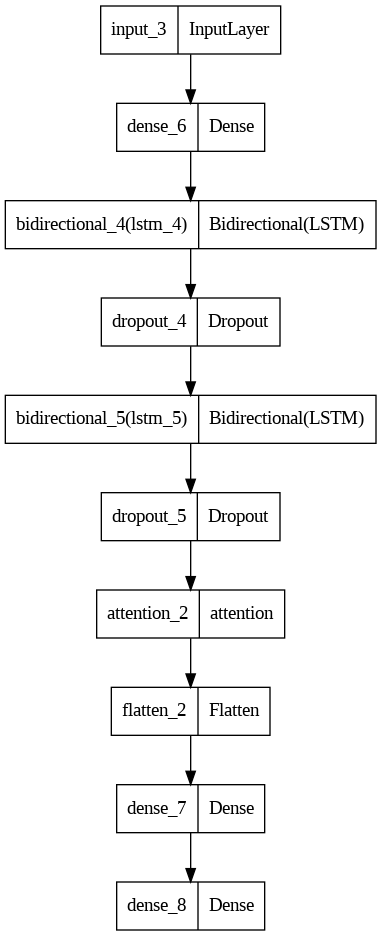

In [38]:
tf.keras.utils.plot_model(model)

In [45]:
inputs = Input(shape=(n_features,1))

Dense1 = Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2())(inputs)

lstm_1=  Bidirectional(LSTM(128, return_sequences = True))(Dense1)
drop = Dropout(0.3)(lstm_1)
#lstm_3=  Bidirectional(LSTM(128, return_sequences = True))(drop)
#drop2 = Dropout(0.3)(drop)
#attention_1 = attention()(drop)
#drop = Dropout(0.3)(attention_1)
flat = Flatten()(drop)

Dense_2 = Dense(128, activation = 'relu')(flat)
outputs = Dense(1, activation='sigmoid')(Dense_2)

model2 = tf.keras.Model(inputs, outputs)

model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 11, 1)]           0         
                                                                 
 dense_9 (Dense)             (None, 11, 64)            128       
                                                                 
 bidirectional_6 (Bidirectio  (None, 11, 256)          197632    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 11, 256)           0         
                                                                 
 flatten_3 (Flatten)         (None, 2816)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               360576    
                                                           


Epoch 1: val_accuracy improved from -inf to 0.62818, saving model to ./_best_model_singleTrial.h5

Epoch 2: val_accuracy did not improve from 0.62818

Epoch 3: val_accuracy did not improve from 0.62818

Epoch 4: val_accuracy did not improve from 0.62818

Epoch 5: val_accuracy improved from 0.62818 to 0.62994, saving model to ./_best_model_singleTrial.h5

Epoch 6: val_accuracy did not improve from 0.62994

Epoch 7: val_accuracy improved from 0.62994 to 0.63433, saving model to ./_best_model_singleTrial.h5

Epoch 8: val_accuracy improved from 0.63433 to 0.64135, saving model to ./_best_model_singleTrial.h5

Epoch 9: val_accuracy did not improve from 0.64135

Epoch 10: val_accuracy improved from 0.64135 to 0.64179, saving model to ./_best_model_singleTrial.h5

Epoch 11: val_accuracy improved from 0.64179 to 0.64794, saving model to ./_best_model_singleTrial.h5

Epoch 12: val_accuracy did not improve from 0.64794

Epoch 13: val_accuracy improved from 0.64794 to 0.65145, saving model to ./

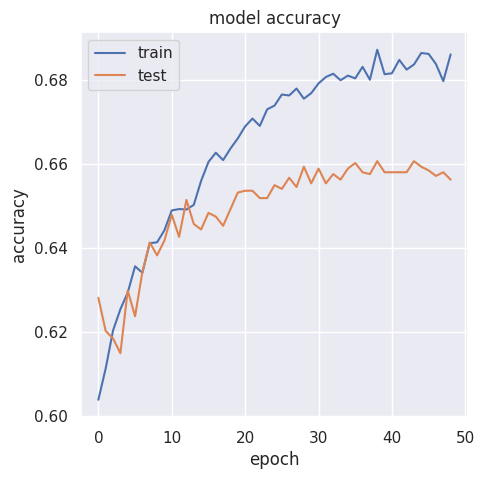

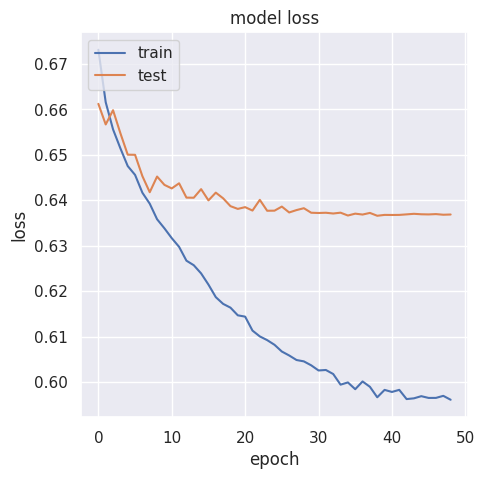

In [47]:
        
model2,history = train_model(model2, x_train, y_train,x_test, y_test, save_to= './', epoch = 50)

72/72 [==============================] - 2s 13ms/step


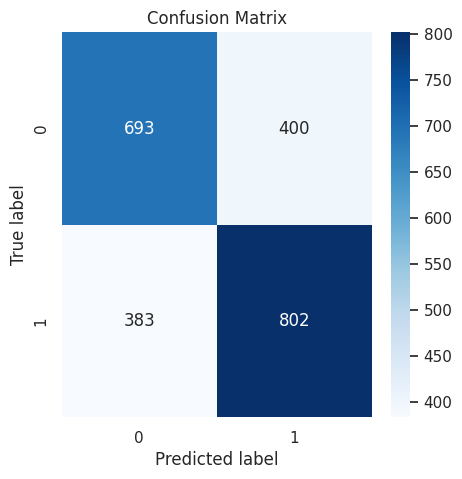

In [48]:
#Generate predictions for the test dataset
ypred = model2.predict(x_test,batch_size = 32).flatten()
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()